In [1]:
from torchvision import transforms
from PIL import Image
from captum.attr import LayerGradCam, FeatureAblation, IntegratedGradients, Saliency, InputXGradient
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import numpy as np
import torch
from models import fcn_resnet50, fcn_resnet101, deeplabv3_resnet50, deeplabv3_resnet101, deeplabv3_mobilenetv3_large
        
        
device = "cuda:0" if torch.cuda.is_available() else "cpu"



image_path = 'assets/images/demo_picture.png'

input_image = Image.open(image_path)
input_image = input_image.resize((int(input_image.width/2), int(input_image.height/2)), resample=Image.LANCZOS)
preprocessing = transforms.Compose([transforms.ToTensor()])
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

input_tensor = preprocessing(input_image)

normalized_inp = normalize(input_tensor).unsqueeze(0).to(device)
normalized_inp.requires_grad = True



def grad_cam(input_tensor, normalized_inp, model, i):
            
    
                    def outputs(normalized_inp, model):
                        
                        out = model(normalized_inp)['out']
                        out_max = torch.argmax(out, dim=1, keepdim=True)

                        return  out_max


                    out_max = outputs(normalized_inp, model)


                    def agg_segmentation_wrapper_grad(inp):
                                model_out = model(inp)['out']
                                # Creates binary matrix with 1 for original argmax class for each pixel
                                # and 0 otherwise. Note that this may change when the input is ablated
                                # so we use the original argmax predicted above, out_max.
                                selected_inds = torch.zeros_like(model_out[0:1]).scatter_(1, out_max, 1)
                                return (model_out * selected_inds).sum(dim=(2,3))



                    def grad_on_image():
                        targets = [2,6,7,14,15,19]

                        layer_gc = LayerGradCam(agg_segmentation_wrapper_grad, model.classifier)

                        for target in targets:
                                    if target in [i]:

                                        gc_attr = layer_gc.attribute(normalized_inp, target=target)
                                        attr_norm = (gc_attr - gc_attr.min()) / (gc_attr.max() - gc_attr.min())
                                        attr_norm_float = attr_norm.detach().numpy().astype(np.float32)
                                        heatmap = attr_norm_float[0,0]
                                        heatmap_fin = cv2.resize(heatmap, (input_tensor.shape[2], input_tensor.shape[1]))

                                        gradcam_img = show_cam_on_image(np.transpose(input_tensor.detach().cpu().numpy(), (1,2,0)), heatmap_fin, use_rgb=True)

                                        gradcam_img = Image.fromarray(gradcam_img)

                                        return gradcam_img
                                    
                    gradcam_on_image = grad_on_image()

                    return gradcam_on_image
               
                
                



/Users/finnschurmann/anaconda3/envs/xAI_Dashboard/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
model = fcn_resnet50()

i = 15
gradcam = grad_cam(input_tensor, normalized_inp, model, i)

Using cache found in /Users/finnschurmann/.cache/torch/hub/pytorch_vision_v0.10.0


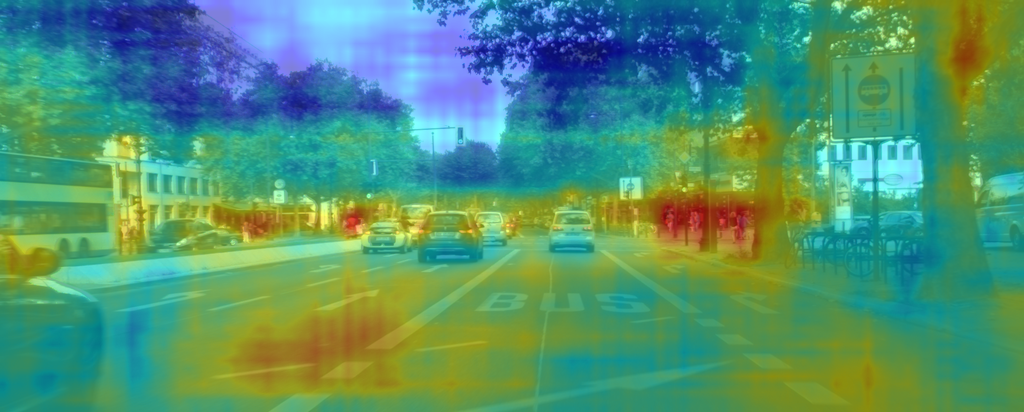

In [9]:
gradcam